**Task 2 : Reconstructing using Random Fourier Features (RFF) [3 marks]**

**2.** Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time
(
t
)
 to amplitude
(
A
)
, where
t
 is the time point, and
A
 is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


Here I have downloaded the necessary libraries to complete the task. Then setting the device for computation (CPU, GPU, or MPS).

In [ ]:
from IPython.display import Audio

In [ ]:
import torchaudio

file_path = '/content/claps-44774.mp3'

try:
    audio, sr = torchaudio.load(file_path)
except RuntimeError as e:
    print(f"Error loading audio: {e}")

print(f"Loaded audio shape: {audio.shape}, Sample rate: {sr} Hz")


Loaded audio shape: torch.Size([2, 114048]), Sample rate: 24000 Hz


Here loading the audio from an MP3 file into a tensor. And printing the shape of the audio, sample rate.

In [ ]:
audio = audio[0]
print(f"Audio shape after selecting first channel: {audio.shape}")

Audio shape after selecting first channel: torch.Size([114048])


Here audio is a tensor with two dimensions for stereo sound (channels and samples). The first channel is selected using audio = audio[0], for printing the shape of the audio and its sample rate.

In [ ]:
tm = len(audio) / sr  # len(audio) gives the number of samples in 1D
print(f"Audio length: {tm} seconds")

Audio length: 4.752 seconds


"tm" computes the audio length in seconds and the len(audio) gives the number of samples, and dividing it by samples per second gives the time duration.


In [ ]:
audio

tensor([ 0.0000e+00,  2.0998e-16, -2.4791e-17,  ..., -2.2997e-08,
        -6.3079e-09, -6.0046e-08])

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

Here plots the audio signal with respect to time. And time in seconds on the x-axis and amplitude on the y-axis.

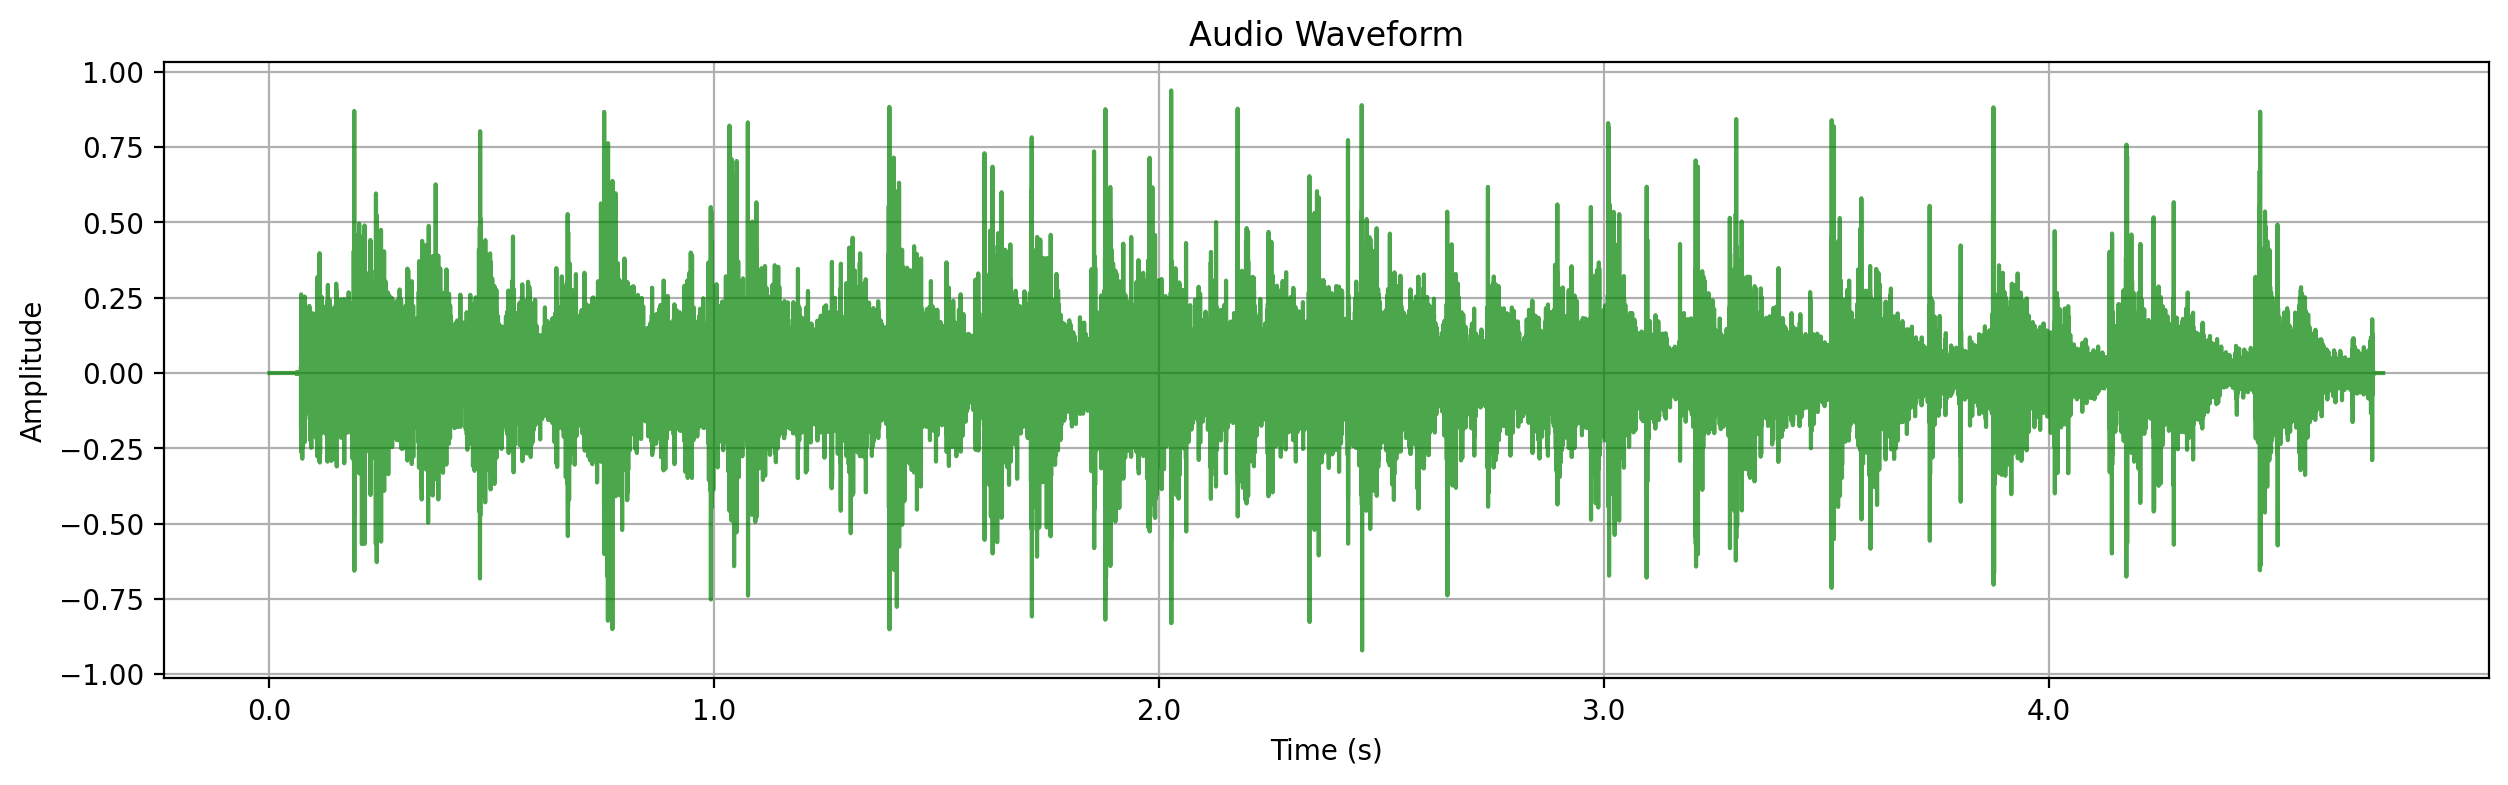

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([114048, 1])
tensor([[-100.0000],
        [ -99.9982],
        [ -99.9965],
        ...,
        [  99.9965],
        [  99.9982],
        [ 100.0000]])


Here, created a 1D tensor X that ranges from 0 to the length of the audio signal, representing the time values for each sample. This ensures that the time values are scaled to a range, which helps with RFF transformation.

In [ ]:
Audio(audio, rate = sr)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for reproducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

Here, The create_rff_features() function uses the RBFSampler to map X into a high-dimensional space using RFF. It returns a tensor with num_features features.

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([114048, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0059, -0.0191, -0.0190,  ..., -0.0197,  0.0088, -0.0082],
        [ 0.0029, -0.0198, -0.0189,  ..., -0.0199,  0.0104, -0.0109],
        ...,
        [-0.0127, -0.0199, -0.0147,  ...,  0.0050, -0.0032, -0.0101],
        [-0.0102, -0.0194, -0.0145,  ...,  0.0059, -0.0013, -0.0126],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(114048,)


The LinearRegression() model is trained using the RFF-transformed input X_rff to predict the original audio signal

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
print(pred_audio)
print(audio)

[-0.05049553 -0.03583707 -0.02248719 ...  0.08150987  0.08093372
  0.07575609]
tensor([ 0.0000e+00,  2.0998e-16, -2.4791e-17,  ..., -2.2997e-08,
        -6.3079e-09, -6.0046e-08])


In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(37.00607, 9043.739)

In [ ]:
Audio(pred_audio, rate = sr)

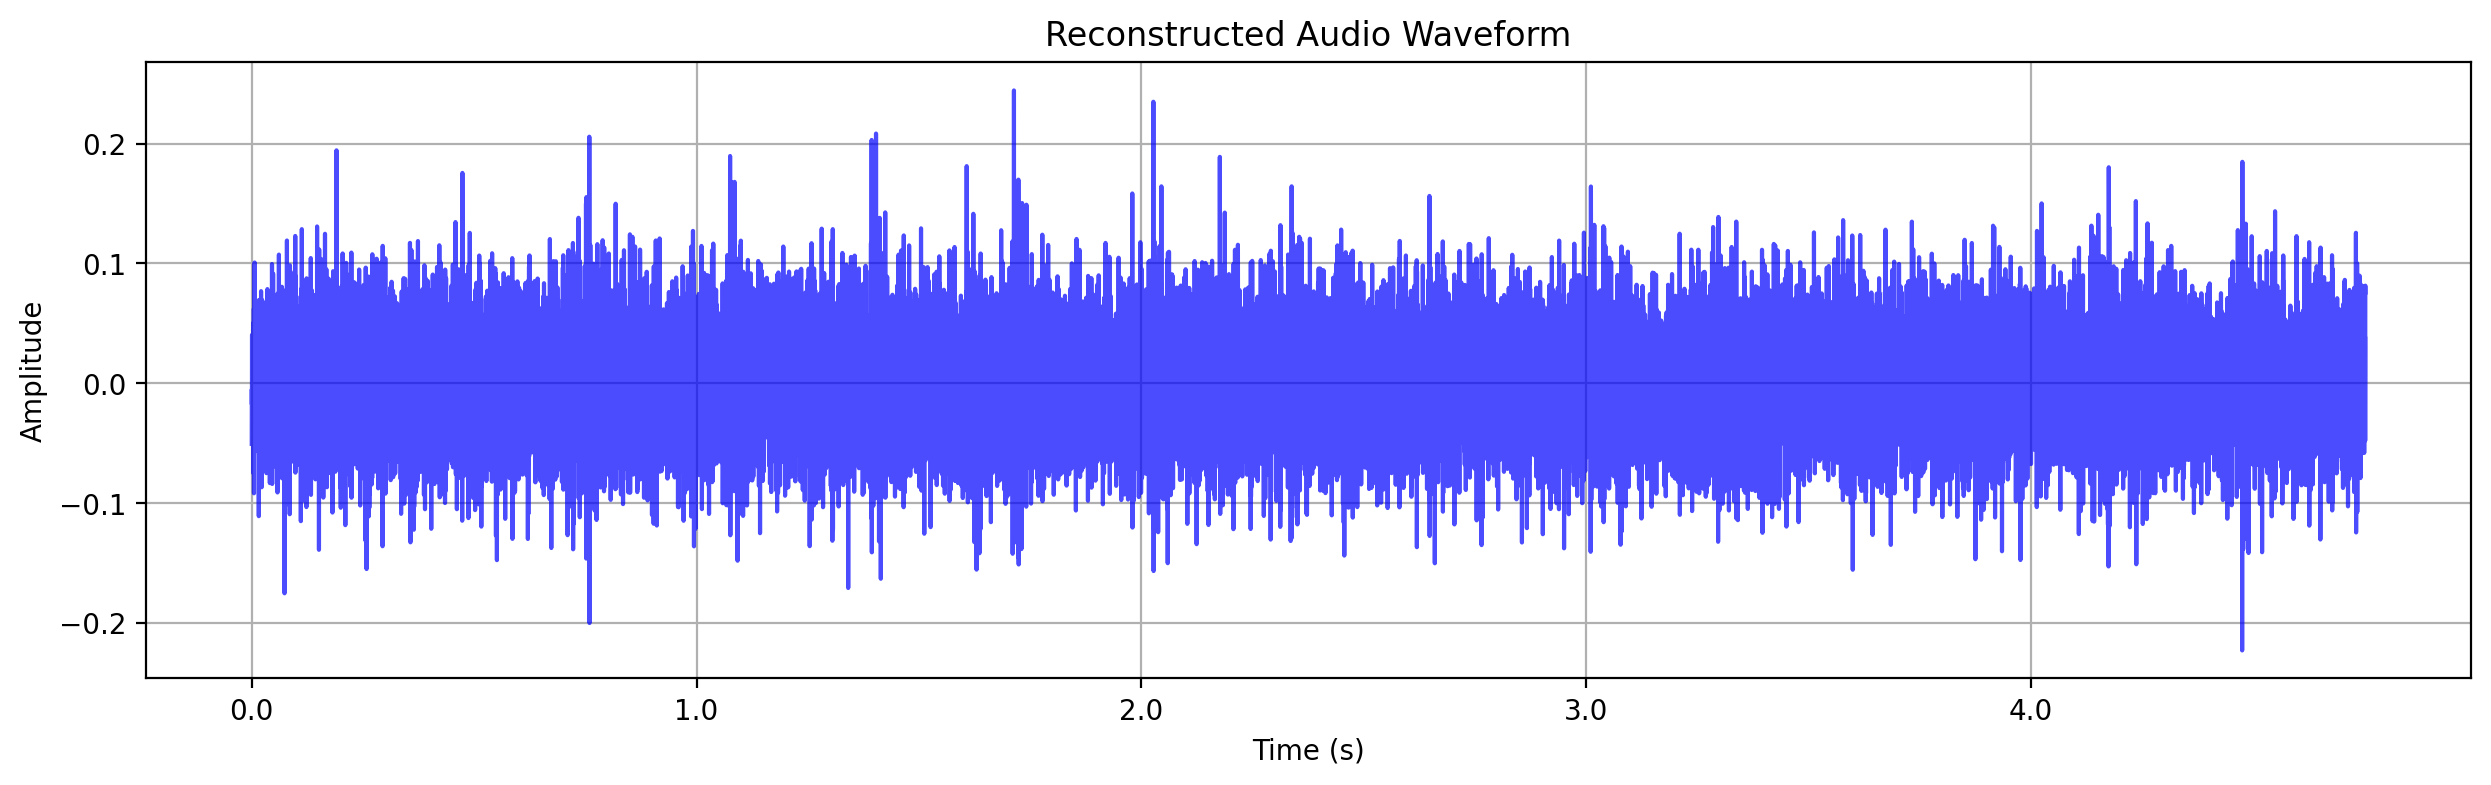

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

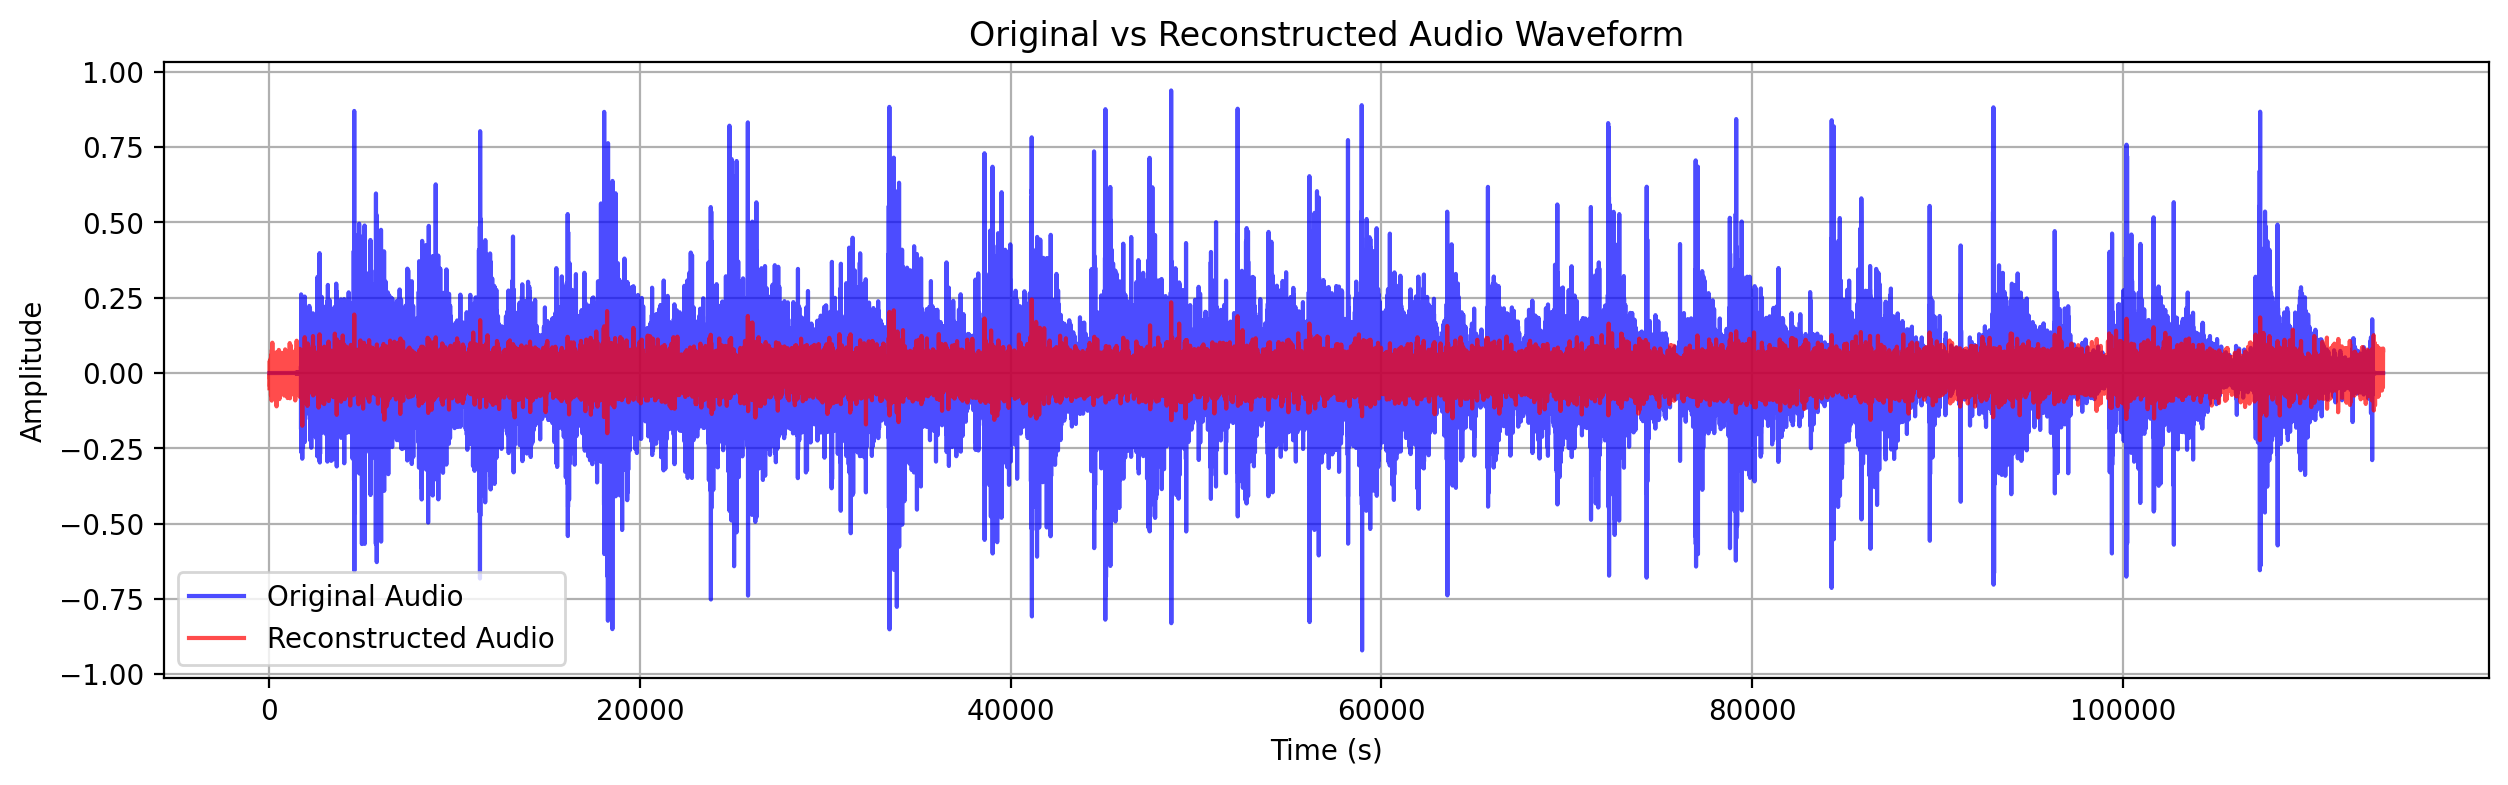

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(audio.numpy(), pred_audio))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# SNR (Signal-to-Noise Ratio)
signal_power = np.mean(audio.numpy() ** 2)
noise_power = np.mean((audio.numpy() - pred_audio) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

Root Mean Squared Error (RMSE): 0.10957945138216019
Signal-to-Noise Ratio (SNR): 0.5618061497807503 dB


**Task 3 : Super-Resolution using Random Fourier Features (RFF) [4 Marks]**

**1.**Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
import os
from PIL import Image
from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing

# Set env CUDA_LAUNCH_BLOCKING=1 and device
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display for better quality images
%config InlineBackend.figure_format = 'retina'

# Install einops if necessary
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [ ]:
# Check if the image exists, if not download it
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


torch.Size([3, 1365, 2048])


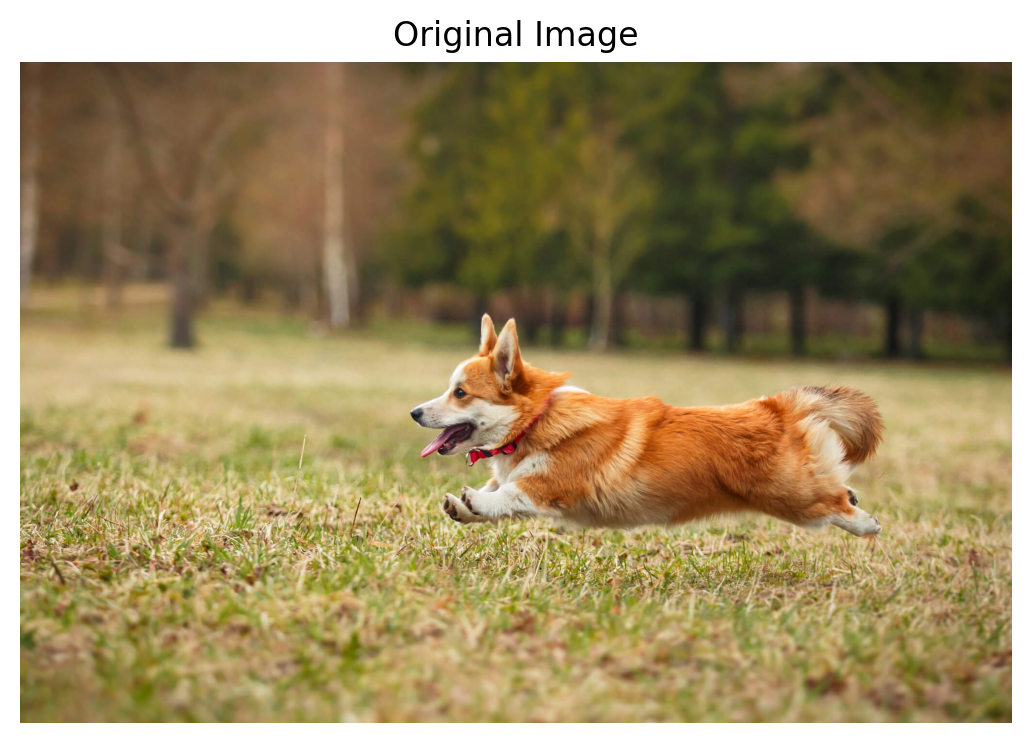

In [ ]:
# Read the image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)  # Check the image shape
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Crop the image to 400x400 (the high-resolution version)
crop = torchvision.transforms.functional.crop(img, 600, 800, 400, 400)
print(f"Cropped Image Shape (400x400): {crop.shape}")

Cropped Image Shape (400x400): torch.Size([3, 400, 400])


In [ ]:
# Convert the cropped image to float and normalize the pixel values
img_scaled = crop.float() / 255.0
img_scaled = img_scaled.to(device)

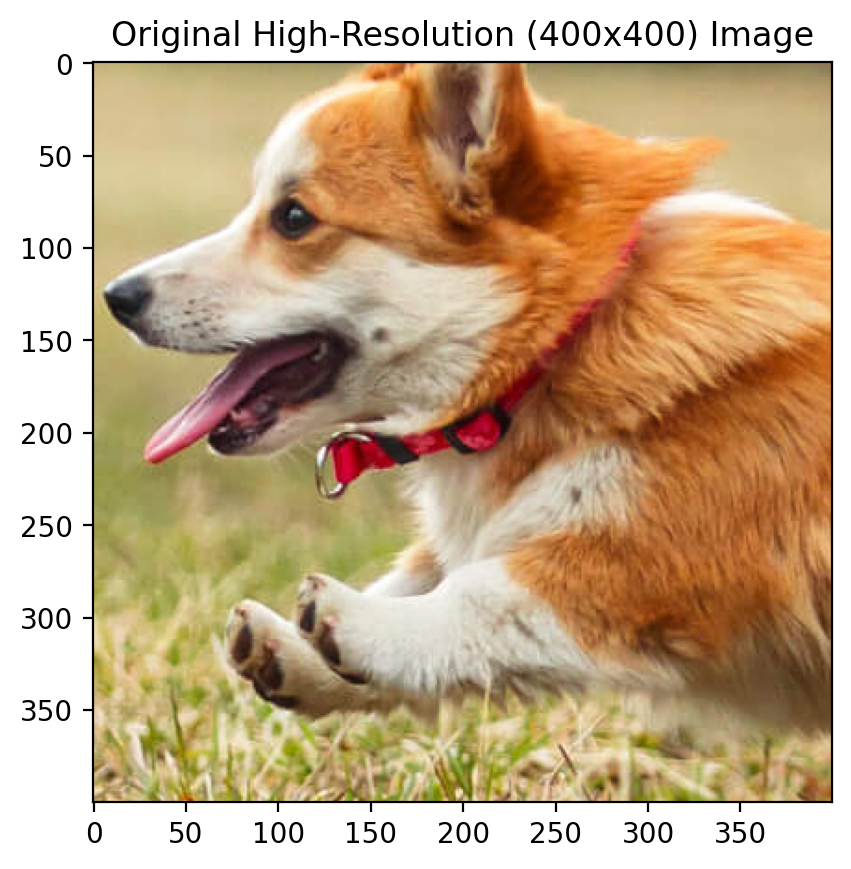

In [ ]:
# Normalize the cropped image if needed
crop_normalized = crop / crop.max()  # Ensure the values are between 0 and 1

# Display the cropped high-resolution image
plt.imshow(rearrange(crop_normalized, 'c h w -> h w c').cpu().numpy())
plt.title("Original High-Resolution (400x400) Image")
plt.show()

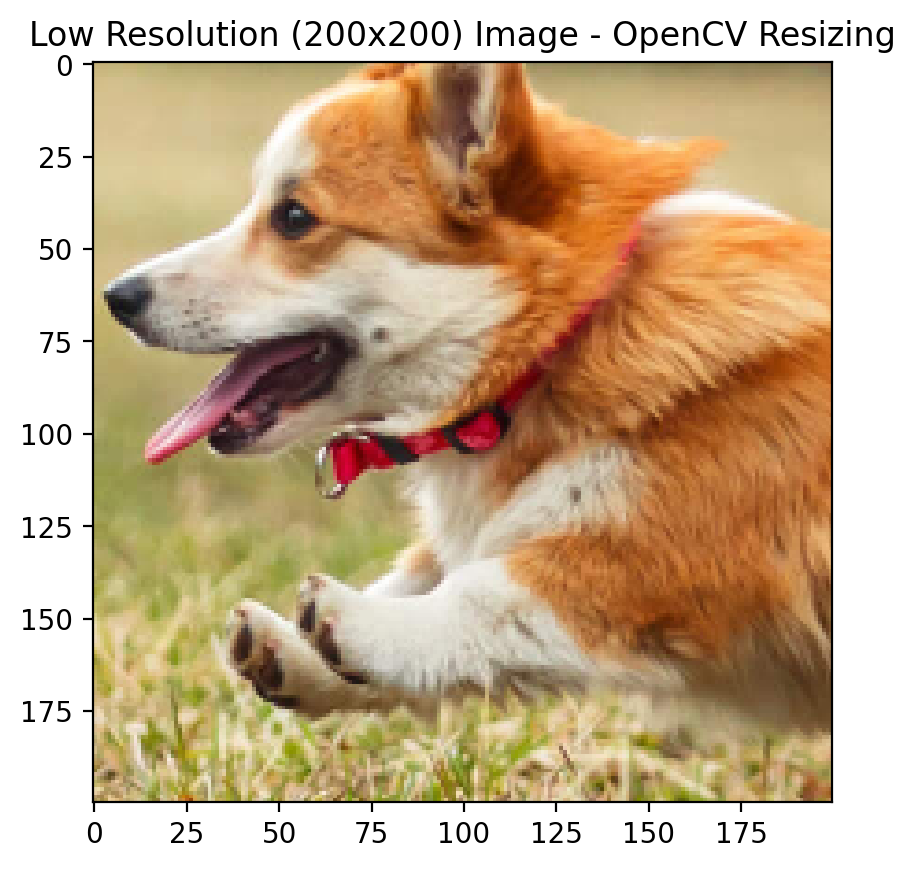

In [ ]:
import cv2

# Convert the image tensor to a NumPy array and rearrange it for OpenCV (from CHW to HWC)
img_np = rearrange(crop, 'c h w -> h w c').cpu().numpy()

# Resize the 400x400 image to 200x200 using OpenCV's resize function
low_res_image_cv2 = cv2.resize(img_np, (200, 200), interpolation=cv2.INTER_AREA)
low_res_image_cv2 = low_res_image_cv2 / 255.0  # Normalize the pixel values

# Convert the resized image back to a tensor and rearrange it back to CHW (from HWC)
low_res_image_cv2_tensor = torch.tensor(rearrange(low_res_image_cv2, 'h w c -> c h w')).float().to(device)

# Display the low-resolution image resized using OpenCV
plt.imshow(low_res_image_cv2)
plt.title("Low Resolution (200x200) Image - OpenCV Resizing")
plt.show()

In [ ]:
num_channels, height, width = crop.shape
print(f"Original Cropped Image Shape: {num_channels} {height} {width}")


Original Cropped Image Shape: 3 400 400


In [ ]:
num_channels, height, width = low_res_image_cv2_tensor.shape
print(f"Resized Image Shape: {num_channels} {height} {width}")

Resized Image Shape: 3 200 200


In [ ]:
num_channels, height, width = 2, 3, 4

# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
X.shape

torch.Size([12, 2])

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
low_res_image_cv2_X, low_res_image_cv2_Y = create_coordinate_map(low_res_image_cv2_tensor)
print(low_res_image_cv2_X.shape, low_res_image_cv2_Y.shape)

torch.Size([40000, 2]) torch.Size([40000, 3])


In [ ]:
from sklearn import preprocessing
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_image_cv2_X.cpu())
scaler_Y = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_image_cv2_Y.cpu())

# Scale the X coordinates
low_res_image_cv2_X_scaled = scaler_X.transform(low_res_image_cv2_X.cpu())

# Scale the Y coordinates
low_res_image_cv2_Y_scaled = scaler_Y.transform(low_res_image_cv2_Y.cpu())

# Move the scaled X coordinates to the GPU
low_res_image_cv2_X_scaled = torch.tensor(low_res_image_cv2_X_scaled).to(device)
low_res_image_cv2_Y_scaled = torch.tensor(low_res_image_cv2_Y_scaled).to(device)

# Set to dtype float32
low_res_image_cv2_X_scaled = low_res_image_cv2_X_scaled.float()
low_res_image_cv2_Y_scaled = low_res_image_cv2_Y_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
X_rff = create_rff_features(low_res_image_cv2_X_scaled, 25000, 0.001)

In [ ]:
X_rff.shape

torch.Size([40000, 25000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.00001, X_rff, low_res_image_cv2_Y, 25000)

Epoch 0 loss: 0.369648
Epoch 100 loss: 0.368428
Epoch 200 loss: 0.367214
Epoch 300 loss: 0.366007
Epoch 400 loss: 0.364805
Epoch 500 loss: 0.363608
Epoch 600 loss: 0.362417
Epoch 700 loss: 0.361230
Epoch 800 loss: 0.360048
Epoch 900 loss: 0.358871
Epoch 1000 loss: 0.357698
Epoch 1100 loss: 0.356528
Epoch 1200 loss: 0.355363
Epoch 1300 loss: 0.354202
Epoch 1400 loss: 0.353045
Epoch 1500 loss: 0.351891
Epoch 1600 loss: 0.350741
Epoch 1700 loss: 0.349595
Epoch 1800 loss: 0.348452
Epoch 1900 loss: 0.347312
Epoch 2000 loss: 0.346176
Epoch 2100 loss: 0.345043
Epoch 2200 loss: 0.343913
Epoch 2300 loss: 0.342786
Epoch 2400 loss: 0.341662
Epoch 2500 loss: 0.340541
Epoch 2600 loss: 0.339424
Epoch 2700 loss: 0.338309
Epoch 2800 loss: 0.337197
Epoch 2900 loss: 0.336088
Epoch 3000 loss: 0.334982
Epoch 3100 loss: 0.333878
Epoch 3200 loss: 0.332778
Epoch 3300 loss: 0.331680
Epoch 3400 loss: 0.330585
Epoch 3500 loss: 0.329492
Epoch 3600 loss: 0.328402
Epoch 3700 loss: 0.327315
Epoch 3800 loss: 0.32623

0.146001935005188

In [ ]:
# def plot_reconstructed_and_original_image(original_img, net, X, title=""):
#     """
#     net: torch.nn.Module
#     X: torch.Tensor of shape (num_samples, 2)
#     """
#     # Ensure the original image is on the same device as the model
#     original_img = original_img.to(device)

#     num_channels, height, width = original_img.shape
#     net.eval()
#     with torch.no_grad():
#         outputs = net(X)

#         # Check outputs shape
#         print(f"Outputs shape: {outputs.shape}")

#         # Reshape outputs
#         outputs = outputs.reshape(-1, num_channels, height, width)  # Adjust based on your output
#         outputs = outputs.squeeze(0)  # Remove batch dimension if necessary

#     fig = plt.figure(figsize=(6, 4))
#     gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

#     ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])

#     ax0.imshow(outputs.cpu().permute(1, 2, 0))  # Rearrange for correct display
#     ax0.set_title("Reconstructed Image")

#     ax1.imshow(original_img.cpu().permute(1, 2, 0))  # Rearranging for display
#     ax1.set_title("Original Image")

#     for a in [ax0, ax1]:
#         a.axis("off")

#     fig.suptitle(title, y=0.9)
#     plt.tight_layout()


In [ ]:
# X_rff = create_rff_features(low_res_image_cv2_X_scaled, 25000, 0.008).to(device)


In [ ]:
# X_rff

tensor([[-0.0022,  0.0016,  0.0041,  ..., -0.0088,  0.0004,  0.0075],
        [-0.0073,  0.0061, -0.0081,  ..., -0.0049, -0.0011,  0.0089],
        [ 0.0076, -0.0089, -0.0036,  ...,  0.0022, -0.0026,  0.0078],
        ...,
        [ 0.0038,  0.0079,  0.0082,  ...,  0.0050, -0.0046,  0.0062],
        [ 0.0061, -0.0012, -0.0038,  ...,  0.0088, -0.0058,  0.0087],
        [-0.0083, -0.0064, -0.0080,  ...,  0.0070, -0.0069,  0.0086]],
       device='cuda:0')

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)

        # Reshape based on low-resolution input
        outputs = outputs.reshape(200, 200, num_channels)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

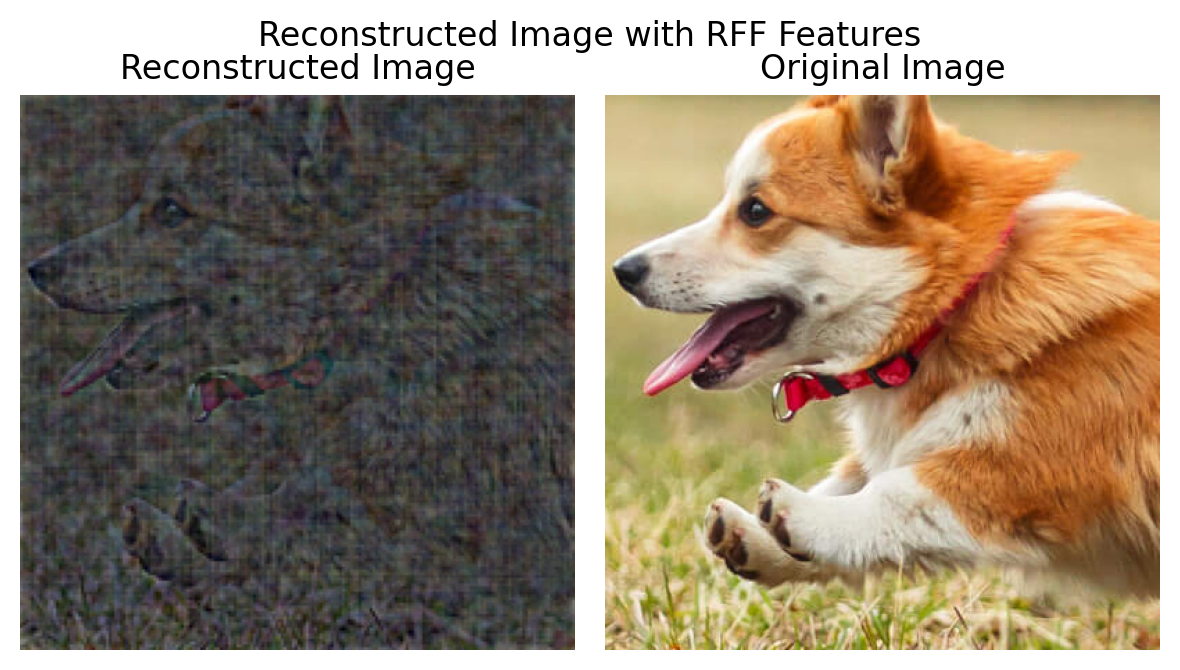

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


**2.**The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

In [ ]:
# Flatten the original and predicted images for RMSE computation
original_flat = crop.cpu().numpy().reshape(-1, 3)
predicted_flat = outputs.cpu().numpy().reshape(-1, 3)

rmse = np.sqrt(mean_squared_error(original_flat, predicted_flat))
print(f"RMSE: {rmse}")

In [ ]:
# Compute PSNR between predicted and original images
def compute_psnr(original, predicted, max_pixel_value=1.0):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
    return psnr

psnr = compute_psnr(original_flat, predicted_flat)
print(f"PSNR: {psnr} dB")

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Flatten the original and predicted images for RMSE computation
original_flat = original_400x400.reshape(-1, 3)
predicted_flat = predicted_400x400.reshape(-1, 3)

# Compute RMSE between the predicted and ground truth high-resolution image
rmse = np.sqrt(mean_squared_error(original_flat, predicted_flat))
print(f"RMSE: {rmse}")

In [ ]:
import math

# Compute PSNR between predicted and original images
def compute_psnr(original, predicted, max_pixel_value=1.0):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
    return psnr

psnr = compute_psnr(original_400x400, predicted_400x400)
print(f"PSNR: {psnr} dB")
